In [178]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime, timedelta
from pathlib import Path

import yfinance as yf


In [179]:
csv_path = Path("dt_reverse_splits.csv")
df = pd.read_csv(csv_path)

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print(df.columns)
df.head()

Index(['symbol', 'effective_date', 'split_ratio', 'current_float_m', 'status'], dtype='object')


,symbol,effective_date,split_ratio,current_float_m,status
0,EOSE,NaN,NaN,310.42,Vote Approved
1,COSM,NaN,NaN,28.47,Vote Approved
2,NXL,NaN,NaN,16.19,Vote Approved
3,AUUD,NaN,NaN,3.09,Vote Approved
4,BURU,NaN,NaN,433.24,Vote Approved


In [180]:
# ticker column
if "symbol" not in df.columns:
    raise ValueError("Expected a 'symbol' column in the CSV.")
df["ticker"] = df["symbol"].astype(str).str.upper().str.strip()

# effective date parsing
if "effective_date" not in df.columns:
    raise ValueError("Expected an 'effective_date' column in the CSV.")
df["effective_date"] = pd.to_datetime(
    df["effective_date"].astype(str).str.strip(),
    errors="coerce"
).dt.date

# status filtering (adjust to match your CSV)
if "status" in df.columns:
    df["status_norm"] = df["status"].astype(str).str.lower()
else:
    df["status_norm"] = ""

# keep rows where effective_date exists
df2 = df[df["effective_date"].notna()].copy()

# optional: only completed (tweak keywords based on your file)
completed_keywords = ["complete", "effective", "implemented"]
df2 = df2[df2["status_norm"].apply(lambda s: any(k in s for k in completed_keywords) or s == "")].copy()

print("Rows with effective_date:", len(df2))
df2[["ticker","effective_date","split_ratio","status" if "status" in df2.columns else "status_norm"]].head(10)


Rows with effective_date: 1785


,ticker,effective_date,split_ratio,status
193,TRT,2026-01-02,0.5,Complete
194,RVYL,2026-01-02,35,Complete
195,CODX,2026-01-02,30,Complete
196,PAVM,2026-01-02,30,Complete
197,RPT,2025-12-31,6,Complete
198,BIYA,2025-12-30,25,Complete
199,ORIS,2025-12-30,20,Complete
200,ILAG,2025-12-30,10,Complete
201,XTKG,2025-12-30,6,Complete
202,ACET,2025-12-30,16,Complete


In [181]:
ENTRY_LAG_DAYS = 30
HOLD_DAYS = 30

df2["entry_date"] = pd.to_datetime(df2["effective_date"]) - pd.to_timedelta(ENTRY_LAG_DAYS, unit="D")
df2["exit_date"]  = df2["entry_date"] + pd.to_timedelta(HOLD_DAYS, unit="D")

# Use date (not datetime)
df2["entry_date"] = df2["entry_date"].dt.date
df2["exit_date"]  = df2["exit_date"].dt.date

df2[["ticker","effective_date","entry_date","exit_date","split_ratio"]].head(15)


,ticker,effective_date,entry_date,exit_date,split_ratio
193,TRT,2026-01-02,2025-12-03,2026-01-02,0.5
194,RVYL,2026-01-02,2025-12-03,2026-01-02,35
195,CODX,2026-01-02,2025-12-03,2026-01-02,30
196,PAVM,2026-01-02,2025-12-03,2026-01-02,30
197,RPT,2025-12-31,2025-12-01,2025-12-31,6
198,BIYA,2025-12-30,2025-11-30,2025-12-30,25
199,ORIS,2025-12-30,2025-11-30,2025-12-30,20
200,ILAG,2025-12-30,2025-11-30,2025-12-30,10
201,XTKG,2025-12-30,2025-11-30,2025-12-30,6
202,ACET,2025-12-30,2025-11-30,2025-12-30,16


In [182]:
tickers = sorted(df2["ticker"].unique().tolist())
tickers[:10], len(tickers)


(['ABEO',
  'ABP',
  'ABTC',
  'ABTS',
  'ABVC',
  'ACB',
  'ACET',
  'ACGN',
  'ACHV',
  'ACON'],
 1199)

In [183]:
import numpy as np
import pandas as pd
import yfinance as yf
import re
from datetime import datetime

df2 = df2.copy()
# -----------------------------
# 1) Determine date range
# -----------------------------
start = pd.to_datetime(df2["entry_date"].min()) - pd.Timedelta(days=14)
end   = pd.to_datetime(df2["exit_date"].max())  + pd.Timedelta(days=14)

print("Price range:", start.date(), "->", end.date())

# -----------------------------
# 2) Download RAW Close (NOT Adj Close)
# -----------------------------
px = yf.download(
    tickers=tickers,
    start=start.strftime("%Y-%m-%d"),
    end=end.strftime("%Y-%m-%d"),
    auto_adjust=False,
    group_by="ticker",
    progress=True
)

close = pd.DataFrame(index=px.index)

if isinstance(px.columns, pd.MultiIndex):
    if "Close" in px.columns.get_level_values(0):
        close = px["Close"].copy()
    else:
        close = px.xs("Close", axis=1, level=1)
else:
    close[tickers[0]] = px["Close"]

close = close.dropna(how="all")


Price range: 2019-10-16 -> 2026-01-16


[*******               15%                       ]  179 of 1199 completedFailed to get ticker 'SUMR' reason: Expecting value: line 1 column 1 (char 0)
[********              16%                       ]  188 of 1199 completedFailed to get ticker 'SRRA' reason: Expecting value: line 1 column 1 (char 0)
[********              17%                       ]  201 of 1199 completedFailed to get ticker 'TMBR' reason: Expecting value: line 1 column 1 (char 0)
[**********************57%**                     ]  678 of 1199 completedFailed to get ticker 'TCS' reason: Expecting value: line 1 column 1 (char 0)
[**********************70%*********              ]  834 of 1199 completedFailed to get ticker 'FRES' reason: Expecting value: line 1 column 1 (char 0)
[**********************89%******************     ]  1070 of 1199 completedFailed to get ticker 'FSTX' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1199 of 1199 completed

189 Failed downloa

In [184]:
import ftplib
import io
import os
from datetime import datetime, timezone
from typing import Iterable, Optional

import pandas as pd

FTP_HOST = "ftp2.interactivebrokers.com"
FTP_USER = "shortstock"
FTP_PASS = ""
FTP_FILE = os.getenv("IBKR_FTP_FILE", "usa.txt")

def fetch_ibkr_shortstock_file(filename: str = FTP_FILE) -> pd.DataFrame:
    """
    Download IBKR shortstock file and parse into a DataFrame.
    File is pipe-delimited with a header line starting '#SYM|...'.
    """
    ftp = ftplib.FTP(FTP_HOST)
    ftp.login(user=FTP_USER, passwd=FTP_PASS)

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    header_idx = next((i for i, ln in enumerate(lines) if ln.startswith("#SYM|")), None)
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_cols = [c.strip().lstrip("#").lower() for c in lines[header_idx].split("|")]
    data_lines = lines[header_idx + 1 :]

    df = pd.read_csv(io.StringIO("\n".join(data_lines)), sep="|", header=None, engine="python")
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]
    return df


def get_borrow_snapshot(tickers: Optional[Iterable[str]] = None) -> pd.DataFrame:
    """
    Returns columns:
      asof_utc, ticker, borrow_annual, rebate_annual, fee_annual, available

    borrow_annual is (feerate - rebaterate) clipped at 0, expressed as decimal annual rate.
    """
    df = fetch_ibkr_shortstock_file()

    df = df.copy()
    df["ticker"] = df["sym"].astype(str).str.upper().str.strip()

    # IBKR rates are percentages in the file; convert to decimals
    df["rebate_annual"] = pd.to_numeric(df.get("rebaterate"), errors="coerce") / 100.0
    df["fee_annual"]    = pd.to_numeric(df.get("feerate"), errors="coerce") / 100.0
    df["available"]     = pd.to_numeric(df.get("available"), errors="coerce")

    df["borrow_annual"] = (df["fee_annual"] - df["rebate_annual"]).clip(lower=0.0)

    if tickers is not None:
        tset = {str(t).upper().strip() for t in tickers}
        df = df[df["ticker"].isin(tset)]

    df["asof_utc"] = datetime.now(timezone.utc).isoformat()

    return df[["asof_utc", "ticker", "borrow_annual", "rebate_annual", "fee_annual", "available"]].dropna(subset=["ticker"])


In [185]:
tickers

['ABEO',
 'ABP',
 'ABTC',
 'ABTS',
 'ABVC',
 'ACB',
 'ACET',
 'ACGN',
 'ACHV',
 'ACON',
 'ACOR',
 'ACXP',
 'ADIL',
 'ADN',
 'ADTX',
 'ADVM',
 'ADXN',
 'ADXS',
 'AEHL',
 'AEI',
 'AEMD',
 'AEON',
 'AEVA',
 'AEY',
 'AFMD',
 'AGEN',
 'AGMH',
 'AGRX',
 'AHI',
 'AHT',
 'AIFF',
 'AIFU',
 'AIHS',
 'AIM',
 'AIMD',
 'AIRI',
 'AIU',
 'AIXC',
 'AIXI',
 'AKA',
 'AKAN',
 'AKTX',
 'ALAR',
 'ALBT',
 'ALCE',
 'ALGS',
 'ALLR',
 'ALPP',
 'ALUR',
 'ALZN',
 'AMBO',
 'AMBR',
 'AMC',
 'AMIX',
 'AMPE',
 'AMRN',
 'AMST',
 'AMTD',
 'AMWL',
 'AMZE',
 'ANGH',
 'ANY',
 'APEX',
 'APLM',
 'APM',
 'APRE',
 'APRN',
 'APTO',
 'APVO',
 'AQB',
 'AQMS',
 'ARBB',
 'ARBK',
 'AREB',
 'ARQQ',
 'ARTL',
 'ARVL',
 'ASAP',
 'ASLN',
 'ASMB',
 'ASNS',
 'ASPS',
 'ASRT',
 'ASST',
 'ASTC',
 'ASTI',
 'ASTR',
 'ASXC',
 'ATCH',
 'ATER',
 'ATHA',
 'ATHE',
 'ATHX',
 'ATIP',
 'ATLN',
 'ATNM',
 'ATNX',
 'ATON',
 'ATPC',
 'ATRA',
 'ATXG',
 'ATXI',
 'ATXS',
 'AUID',
 'AUMN',
 'AUUD',
 'AUVI',
 'AVCT',
 'AVEO',
 'AVGR',
 'AVTX',
 'AVX',
 'AWH',

In [186]:
from pathlib import Path

out = Path("data/borrow_history.csv")
snap = get_borrow_snapshot(tickers)
snap

,asof_utc,ticker,borrow_annual,rebate_annual,fee_annual,available
70,2026-01-06T18:10:19.734519+00:00,ABEO,0.000000,0.029680,0.006720,1600000.0
89,2026-01-06T18:10:19.734519+00:00,ABP,2.331676,-1.147638,1.184038,4000.0
99,2026-01-06T18:10:19.734519+00:00,ABTC,0.080380,-0.021990,0.058390,3600000.0
100,2026-01-06T18:10:19.734519+00:00,ABTS,0.222502,-0.093051,0.129451,2000.0
102,2026-01-06T18:10:19.734519+00:00,ABVC,0.269482,-0.116541,0.152941,100000.0
...,...,...,...,...,...,...
17085,2026-01-06T18:10:19.734519+00:00,ZIVO,0.491732,-0.227666,0.264066,10000.0
17092,2026-01-06T18:10:19.734519+00:00,ZKIN,0.480286,-0.221943,0.258343,350000.0
17106,2026-01-06T18:10:19.734519+00:00,ZNB,0.654078,-0.308839,0.345239,100000.0
17148,2026-01-06T18:10:19.734519+00:00,ZVRA,0.000000,0.033243,0.003157,1300000.0


In [187]:
out.parent.mkdir(parents=True, exist_ok=True)
snap.to_csv(out, index=False)


count    917.000000
mean       0.666166
std        1.480339
min        0.000000
25%        0.013680
50%        0.155802
75%        0.609612
max       18.802406
Name: borrow_annual, dtype: float64


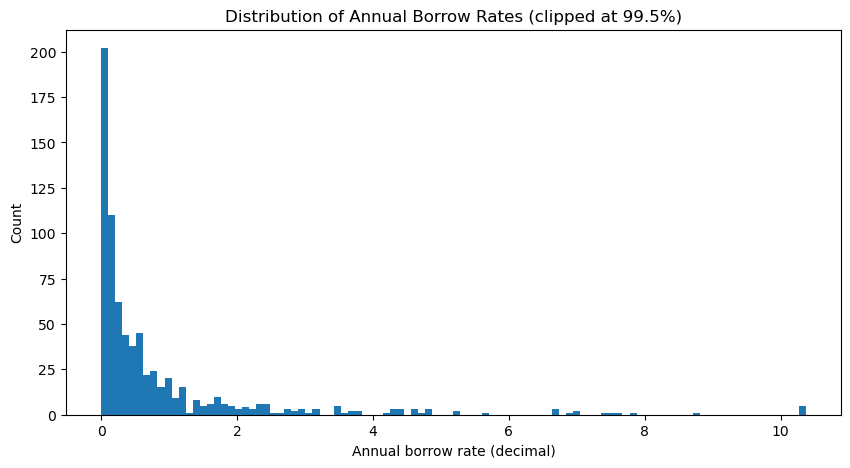

In [188]:
import pandas as pd
import matplotlib.pyplot as plt

bh = pd.read_csv("data/borrow_history.csv")

# Basic inspection
print(bh["borrow_annual"].describe())

# Heuristic unit check: if median > 2, it's probably in percent
if bh["borrow_annual"].median() > 2:
    print("⚠️ borrow_annual looks like PERCENT units — converting to decimal")
    bh["borrow_annual"] = bh["borrow_annual"] / 100.0

# Drop zero / missing
x = bh["borrow_annual"].dropna()
x = x[x > 0]

# Optional: clip extreme tail for visualization
x_clip = x.clip(upper=x.quantile(0.995))

plt.figure(figsize=(10, 5))
plt.hist(x_clip, bins=100)
plt.xlabel("Annual borrow rate (decimal)")
plt.ylabel("Count")
plt.title("Distribution of Annual Borrow Rates (clipped at 99.5%)")
plt.show()



In [219]:
import numpy as np
import pandas as pd

BORROW_CUTOFF = 0.11  # 20% annual, decimal

prices = close.copy()
prices.index = pd.to_datetime(prices.index)

# ---- build borrow_map from latest snapshot ----
snap2 = snap.copy()
snap2["ticker"] = snap2["ticker"].astype(str).str.upper().str.strip()
snap2["borrow_annual"] = pd.to_numeric(snap2["borrow_annual"], errors="coerce")

borrow_map = (
    snap2.dropna(subset=["ticker"])
         .drop_duplicates(subset=["ticker"], keep="last")
         .set_index("ticker")["borrow_annual"]
         .to_dict()
)

def get_next_close(prices: pd.DataFrame, ticker: str, d):
    if ticker not in prices.columns:
        return np.nan, None
    dt = pd.to_datetime(d)
    pos = prices.index.searchsorted(dt)
    if pos >= len(prices.index):
        return np.nan, None
    date_used = prices.index[pos]
    px = prices.iloc[pos][ticker]
    return (float(px) if pd.notna(px) else np.nan), date_used

rows = []

for r in df2.itertuples(index=False):
    ticker = str(r.ticker).upper().strip()

    # Borrow gate (missing borrow => exclude)
    b = borrow_map.get(ticker, np.inf)
    if not np.isfinite(b) or b >= BORROW_CUTOFF:
        continue

    entry_px, entry_used = get_next_close(prices, ticker, r.entry_date)
    exit_px,  exit_used  = get_next_close(prices, ticker, r.exit_date)

    if (
        entry_used is None
        or exit_used is None
        or not np.isfinite(entry_px)
        or not np.isfinite(exit_px)
        or entry_px <= 0
    ):
        continue

    split_mult = getattr(r, "split_multiplier_old_per_new", np.nan)
    if not np.isfinite(split_mult) or split_mult <= 0:
        split_mult = 1.0

    rows.append({
        "ticker": ticker,
        "borrow_annual": float(b),

        "entry_date_used": entry_used,
        "exit_date_used":  exit_used,
        "effective_date":  pd.to_datetime(r.effective_date),
        "split_multiplier_old_per_new": float(split_mult),

        "entry_price_raw": entry_px,
        "exit_price_raw":  exit_px,
    })

trades = pd.DataFrame(rows)

print(f"Trades created (borrow<{BORROW_CUTOFF:.2f}): {len(trades)}")
trades["borrow_annual"].describe()


Trades created (borrow<0.11): 497


count    497.000000
mean       0.027998
std        0.034115
min        0.000000
25%        0.000000
50%        0.007268
75%        0.054972
max        0.107062
Name: borrow_annual, dtype: float64

In [220]:
TOTAL_GROSS = 250_000.0
MAX_PER_NAME = 5_000.0
STOP_LEVEL_PRE = 1.25
STOP_CONSEC = 1

# prices: raw close DF (index=datetime, cols=tickers)
prices = close.copy()
prices.index = pd.to_datetime(prices.index)

trades2 = trades.copy()
trades2["ticker"] = trades2["ticker"].astype(str).str.upper().str.strip()
trades2["entry_dt"] = pd.to_datetime(trades2["entry_date_used"])
trades2["exit_dt"]  = pd.to_datetime(trades2["exit_date_used"])
trades2["eff_dt"]   = pd.to_datetime(trades2["effective_date"])
trades2["split_mult"] = pd.to_numeric(trades2["split_multiplier_old_per_new"], errors="coerce").fillna(1.0)
trades2.loc[trades2["split_mult"] <= 0, "split_mult"] = 1.0

def next_trading_day(idx: pd.DatetimeIndex, d: pd.Timestamp):
    pos = idx.searchsorted(d)
    if pos >= len(idx):
        return None
    return idx[pos]
def compute_forced_exit(row):
    """
    If pre-split price crosses >= STOP_LEVEL_PRE,
    force exit at EXACTLY STOP_LEVEL_PRE (pre-split),
    regardless of actual market price.

    Returns:
        exit_dt, forced_exit_price_raw (or None if no force)
    """
    t = row["ticker"]
    if t not in prices.columns:
        return row["exit_dt"], None

    idx = prices.index
    entry = next_trading_day(idx, row["entry_dt"])
    exit_  = next_trading_day(idx, row["exit_dt"])
    if entry is None or exit_ is None or entry >= exit_:
        return row["exit_dt"], None

    px = prices.loc[entry:exit_, t].copy()
    if px.empty:
        return row["exit_dt"], None

    # Build pre-split price series
    pre = px.copy()
    pre.loc[pre.index >= row["eff_dt"]] = (
        pre.loc[pre.index >= row["eff_dt"]] / float(row["split_mult"])
    )

    # First date crossing stop
    hit = pre[pre >= STOP_LEVEL_PRE]
    if hit.empty:
        return row["exit_dt"], None

    trigger_date = hit.index[0]

    # Exit date bookkeeping: same day or next trading day
    pos = idx.get_loc(trigger_date)
    forced_exit_dt = idx[pos + 1] if pos + 1 < len(idx) else trigger_date

    # Convert limit price back to RAW price space
    if trigger_date >= row["eff_dt"]:
        forced_exit_price_raw = STOP_LEVEL_PRE * float(row["split_mult"])
    else:
        forced_exit_price_raw = STOP_LEVEL_PRE

    return min(forced_exit_dt, row["exit_dt"]), forced_exit_price_raw


trades2[["exit_dt", "forced_exit_price_raw"]] = (
    trades2.apply(
        lambda r: pd.Series(compute_forced_exit(r)),
        axis=1
    )
)



In [221]:
trades2.tail(50)

,ticker,borrow_annual,entry_date_used,exit_date_used,effective_date,split_multiplier_old_per_new,entry_price_raw,exit_price_raw,entry_dt,exit_dt,eff_dt,split_mult,forced_exit_price_raw
447,LDWY,0.034190,2020-12-07,2021-01-04,2021-01-04,1.0,6.930000,7.310000,2020-12-07,2020-12-08,2021-01-04,1.0,1.25
448,ZVRA,0.000000,2020-12-01,2020-12-31,2020-12-31,1.0,16.240000,11.200000,2020-12-01,2020-12-02,2020-12-31,1.0,1.25
449,SNDA,0.000000,2020-11-16,2020-12-14,2020-12-14,1.0,10.500000,15.340000,2020-11-16,2020-11-17,2020-12-14,1.0,1.25
450,SCPX,0.000000,2020-11-10,2020-12-10,2020-12-10,1.0,1456.001465,1301.301270,2020-11-10,2020-11-11,2020-12-10,1.0,1.25
451,EYPT,0.000000,2020-11-09,2020-12-09,2020-12-09,1.0,4.200000,4.490000,2020-11-09,2020-11-10,2020-12-09,1.0,1.25
452,NCSM,0.000488,2020-11-02,2020-12-01,2020-12-01,1.0,14.700000,21.500000,2020-11-02,2020-11-03,2020-12-01,1.0,1.25
453,NVNO,0.000000,2020-11-02,2020-11-30,2020-11-30,1.0,7.900000,7.390000,2020-11-02,2020-11-03,2020-11-30,1.0,1.25
454,DLPN,0.000000,2020-10-26,2020-11-25,2020-11-25,1.0,6.400000,6.900000,2020-10-26,2020-10-27,2020-11-25,1.0,1.25
455,ENSV,0.013404,2020-10-26,2020-11-23,2020-11-23,1.0,2.119489,2.035000,2020-10-26,2020-10-27,2020-11-23,1.0,1.25
456,UAN,0.000000,2020-10-26,2020-11-23,2020-11-23,1.0,7.400000,8.500000,2020-10-26,2020-10-27,2020-11-23,1.0,1.25


In [222]:
raw_rets = prices.pct_change().fillna(0.0)

# Borrow map (assumes snap has ticker + borrow_annual already in DECIMAL)
snap2 = snap.copy()
snap2["ticker"] = snap2["ticker"].astype(str).str.upper().str.strip()
snap2["borrow_annual"] = pd.to_numeric(snap2["borrow_annual"], errors="coerce")

borrow_map = (
    snap2.dropna(subset=["ticker"])
         .drop_duplicates(subset=["ticker"], keep="last")
         .set_index("ticker")["borrow_annual"]
         .to_dict()
)

borrow_annual = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=float)
for t in prices.columns:
    borrow_annual[t] = float(borrow_map.get(t, 0.0) or 0.0)
borrow_daily = borrow_annual / 252.0

# Slippage
SLIPPAGE_BPS = 5
ENTRY_COST = SLIPPAGE_BPS / 10_000.0
EXIT_COST  = SLIPPAGE_BPS / 10_000.0

dates = prices.index
port_ret = pd.Series(0.0, index=dates)

entry_map = trades2.groupby("entry_dt")["ticker"].apply(lambda s: s.unique()).to_dict()
exit_map  = trades2.groupby("exit_dt")["ticker"].apply(lambda s: s.unique()).to_dict()

for d in dates:
    active = trades2[(trades2["entry_dt"] <= d) & (d <= trades2["exit_dt"])]

    if active.empty:
        port_ret.loc[d] = 0.0
        continue

    active = active[active["ticker"].isin(prices.columns)]
    if active.empty:
        port_ret.loc[d] = 0.0
        continue

    tickers_active = active["ticker"].unique().tolist()
    n = len(tickers_active)
    if n == 0:
        port_ret.loc[d] = 0.0
        continue

    # per-name notional: equal-weight until cap
    per_name_notional = min(TOTAL_GROSS / n, MAX_PER_NAME)
    w = per_name_notional / TOTAL_GROSS  # weight per name in portfolio return

    # daily return contribution = sum_i (w * r_short_i)
    total = 0.0
    for tkr in tickers_active:
        tr = active[active["ticker"] == tkr].iloc[0]

        # prior close
        p0 = prices.shift(1).loc[d, tkr]
        if pd.isna(p0) or p0 <= 0:
            r_stock = 0.0
        else:
            # If today is the (forced) exit day and we have a forced exit price, use the limit fill
            if (pd.notna(tr.get("forced_exit_price_raw", np.nan)) and d == tr["exit_dt"]):
                r_stock = (float(tr["forced_exit_price_raw"]) / float(p0)) - 1.0
            else:
                # Normal split-aware daily return
                if d < tr["eff_dt"]:
                    r_stock = float(raw_rets.loc[d, tkr])
                else:
                    p1 = prices.loc[d, tkr]
                    if pd.isna(p1) or p1 <= 0:
                        r_stock = 0.0
                    else:
                        prev_d = prices.index[prices.index.get_loc(d) - 1] if prices.index.get_loc(d) > 0 else None
                        if prev_d is not None and prev_d < tr["eff_dt"] <= d:
                            p0_adj = float(p0) * float(tr["split_mult"])
                        else:
                            p0_adj = float(p0)
                        r_stock = (float(p1) / float(p0_adj)) - 1.0

        r_borrow = float(borrow_daily.loc[d, tkr]) if tkr in borrow_daily.columns else 0.0
        r_short = -r_stock - r_borrow
        total += w * r_short

    # Slippage: charge bps on notional traded / total gross
    entered_today = [t for t in entry_map.get(d, []) if t in tickers_active]
    exited_today  = [t for t in exit_map.get(d, []) if t in tickers_active]

    traded_notional = (len(entered_today) + len(exited_today)) * per_name_notional
    slip = (traded_notional / TOTAL_GROSS) * ENTRY_COST  # same bps scale
    # (If you want different entry vs exit bps, split it:)
    # slip = (len(entered_today)*per_name_notional/TOTAL_GROSS)*ENTRY_COST + (len(exited_today)*per_name_notional/TOTAL_GROSS)*EXIT_COST

    port_ret.loc[d] = total - slip

equity = (1.0 + port_ret).cumprod()
results = pd.DataFrame({"daily_return": port_ret, "equity": equity})
results.tail(100)


C:\Users\werdn\AppData\Local\Temp\ipykernel_12644\146575789.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  raw_rets = prices.pct_change().fillna(0.0)


,daily_return,equity
Date,,
2025-08-14,0.000000,794.579690
2025-08-15,0.000000,794.579690
2025-08-18,-0.001476,793.406593
2025-08-19,0.016778,806.718331
2025-08-20,0.012225,816.580189
...,...,...
2025-12-30,0.000000,1150.509879
2025-12-31,0.000000,1150.509879
2026-01-02,0.000000,1150.509879


In [223]:
equity = results["equity"]

start_val = equity.iloc[0]
end_val   = equity.iloc[-1]

# Use actual calendar time, not number of rows
days = (equity.index[-1] - equity.index[0]).days
years = days / 365.25

cagr = (end_val / start_val) ** (1 / years) - 1

print(f"CAGR: {cagr:.2%}")
print("Start equity:", start_val)
print("End equity:", end_val)
print("Max drawdown:", (equity / equity.cummax() - 1).min())
print("Worst daily return:", port_ret.min())



CAGR: 210.20%
Start equity: 1.0
End equity: 1150.5098791169805
Max drawdown: -0.22129581440524226
Worst daily return: -0.2212958144052423


In [230]:
# Make sure these are serializable
trades2_export = trades2.copy()

# Convert datetime columns to ISO strings for CSV clarity
dt_cols = [c for c in trades2_export.columns if "dt" in c.lower() or "date" in c.lower()]
for c in dt_cols:
    if c in trades2_export.columns:
        trades2_export[c] = pd.to_datetime(trades2_export[c], errors="coerce").dt.strftime("%Y-%m-%d")

# Add a couple helpful diagnostics columns
trades2_export["is_forced_exit"] = trades2_export["forced_exit_price_raw"].notna()

# Per-trade gross short return using entry/exit raw prices (rough; ignores daily path)
# If you have entry/exit raw in trades2:
if "entry_price_raw" in trades2_export.columns and "exit_price_raw" in trades2_export.columns:
    trades2_export["ret_short_gross"] = (
        (pd.to_numeric(trades2_export["entry_price_raw"], errors="coerce") -
         pd.to_numeric(trades2_export["exit_price_raw"], errors="coerce"))
        / pd.to_numeric(trades2_export["entry_price_raw"], errors="coerce")
    )

# Holding days
if "entry_date_used" in trades2_export.columns and "exit_date_used" in trades2_export.columns:
    ed = pd.to_datetime(trades2_export["entry_date_used"], errors="coerce")
    xd = pd.to_datetime(trades2_export["exit_date_used"], errors="coerce")
    trades2_export["holding_days"] = (xd - ed).dt.days

out_path = DATA_DIR / "trades2_export.csv"
trades2_export.to_csv(out_path, index=False)

print("Wrote:", out_path.resolve())


Wrote: C:\Users\werdn\Documents\Investing\reverse-split\src\notebooks\data\trades2_export.csv


In [231]:
# 1) How many forced exits?
print("Forced exits:", trades2["forced_exit_price_raw"].notna().sum(), "of", len(trades2))

# 2) Deployed gross vs TOTAL_GROSS over time (approx)
# We can estimate average # names from your daily loop inputs:
active_counts = []
for d in prices.index:
    active = trades2[(trades2["entry_dt"] <= d) & (d <= trades2["exit_dt"])]
    active = active[active["ticker"].isin(prices.columns)]
    active_counts.append(len(active["ticker"].unique()))
active_counts = pd.Series(active_counts, index=prices.index)
print("Avg names active:", active_counts.mean(), "Median:", active_counts.median(), "Max:", active_counts.max())

# 3) Biggest daily moves
print("Worst daily return:", results["daily_return"].min())
print("Best daily return:", results["daily_return"].max())


Forced exits: 496 of 497
Avg names active: 0.7352941176470589 Median: 0.0 Max: 6
Worst daily return: -0.2212958144052423
Best daily return: 0.09625281460840239


In [194]:
import json

SEC_TICKER_CIK_URL = "https://www.sec.gov/files/company_tickers.json"
CACHE_PATH = Path("sec_company_tickers.json")

HEADERS = {
    "User-Agent": "Drew Goldman (research) drew@example.com",  # <-- put a real email here
    "Accept-Encoding": "gzip, deflate",
    "Host": "www.sec.gov"
}

if not CACHE_PATH.exists():
    r = requests.get(SEC_TICKER_CIK_URL, headers=HEADERS, timeout=30)
    r.raise_for_status()
    CACHE_PATH.write_text(r.text, encoding="utf-8")

mapping = json.loads(CACHE_PATH.read_text(encoding="utf-8"))

# Build dict: ticker -> cik (zero-padded)
ticker_to_cik = {}
for _, row in mapping.items():
    t = row["ticker"].upper()
    cik = str(row["cik_str"]).zfill(10)
    ticker_to_cik[t] = cik

# attach cik
df2["cik"] = df2["ticker"].map(ticker_to_cik)
df2[["ticker","cik"]].head(15)


,ticker,cik
193,TRT,0000732026
194,RVYL,0001419275
195,CODX,0001692415
196,PAVM,0001624326
197,RPT,0001614806
198,BIYA,0001944712
199,ORIS,0001964664
200,ILAG,0001814963
201,XTKG,0001754323
202,ACET,0001720580


In [195]:
from pathlib import Path
import pandas as pd

FUND_CACHE = Path("data/sec_fundamentals_cache.csv")
FUND_CACHE.parent.mkdir(parents=True, exist_ok=True)


In [196]:
if FUND_CACHE.exists():
    try:
        fund_cache = pd.read_csv(
            FUND_CACHE,
            parse_dates=["cash_period_end", "opcf_period_end"]
        )
    except pd.errors.EmptyDataError:
        fund_cache = pd.DataFrame()
else:
    fund_cache = pd.DataFrame()


In [197]:
unique_ciks = sorted(df2["cik"].dropna().unique().tolist())
cached_ciks = set(fund_cache["cik"]) if not fund_cache.empty else set()
needed_ciks = sorted(set(unique_ciks) - cached_ciks)

print(f"CIKs total: {len(unique_ciks)} | cached: {len(cached_ciks)} | to fetch: {len(needed_ciks)}")


CIKs total: 927 | cached: 921 | to fetch: 927


In [198]:
import requests
import time
import random
import pandas as pd

SEC_HEADERS = {
    "User-Agent": "Drew Goldman (research) drew@email.com",
    "Accept-Encoding": "gzip, deflate",
    "Host": "data.sec.gov",
}


def fetch_companyfacts(
    cik,
    *,
    max_retries=5,
    base_sleep=0.6,
    timeout=20
):
    """
    Robust SEC XBRL fetcher with retries + backoff.
    Returns dict or None.
    """
    cik = str(cik).zfill(10)
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"

    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, headers=SEC_HEADERS, timeout=timeout)

            if r.status_code == 404:
                return None  # no facts available

            if r.status_code == 429:
                # rate limited — hard backoff
                sleep = base_sleep * attempt * 2
                time.sleep(sleep + random.uniform(0, 0.5))
                continue

            if r.status_code >= 500:
                # transient server error
                sleep = base_sleep * attempt
                time.sleep(sleep + random.uniform(0, 0.5))
                continue

            r.raise_for_status()
            return r.json()

        except requests.exceptions.RequestException as e:
            if attempt == max_retries:
                print(f"⚠️  SEC fetch failed for CIK {cik}: {e}")
                return None

            sleep = base_sleep * attempt
            time.sleep(sleep + random.uniform(0, 0.5))

    return None


def pick_latest_usd_quarter(facts, tag_candidates):
    """
    Given companyfacts json + list of us-gaap tags,
    find latest quarterly USD value.

    Returns (value, end_date, tag_used) or (None, None, None)
    """
    if facts is None:
        return None, None, None

    gaap = facts.get("facts", {}).get("us-gaap", {})

    for tag in tag_candidates:
        node = gaap.get(tag, {})
        units = node.get("units", {})
        usd = units.get("USD", [])

        if not usd:
            continue

        dfu = pd.DataFrame(usd)

        if "end" not in dfu.columns or "val" not in dfu.columns:
            continue

        dfu["end"] = pd.to_datetime(dfu["end"], errors="coerce")
        dfu = dfu.dropna(subset=["end", "val"])

        if dfu.empty:
            continue

        # prefer quarterly form values (qtrs == 1) if present
        if "qtrs" in dfu.columns:
            q = dfu[dfu["qtrs"] == 1]
            if not q.empty:
                dfu = q

        latest = dfu.sort_values("end").iloc[-1]
        return float(latest["val"]), latest["end"].date(), tag

    return None, None, None


In [199]:
rows = []

cash_tags = [ "CashAndCashEquivalentsAtCarryingValue", "CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents", "Cash" ]
opcf_tags = [ "NetCashProvidedByUsedInOperatingActivities" ]

for cik in needed_ciks:
    facts = fetch_companyfacts(cik)
    if not facts:
        continue

    try:
        cash, cash_end, cash_tag = pick_latest_usd_quarter(facts, cash_tags)
        opcf, opcf_end, opcf_tag = pick_latest_usd_quarter(facts, opcf_tags)

        rows.append({
            "cik": cik,
            "cash": cash,
            "cash_period_end": cash_end,
            "opcf": opcf,
            "opcf_period_end": opcf_end,
            "cash_tag": cash_tag,
            "opcf_tag": opcf_tag,
            "asof_utc": pd.Timestamp.utcnow().isoformat()
        })

    except Exception as e:
        print(f"⚠️  Parse failed for CIK {cik}: {e}")
        continue


In [200]:
from pathlib import Path
import pandas as pd

FUND_CACHE = Path("data/sec_fundamentals_cache.csv")
FUND_CACHE.parent.mkdir(parents=True, exist_ok=True)

# New data from this run
new_fund = pd.DataFrame(rows)

if new_fund.empty:
    print("No new fundamentals fetched.")
else:
    # Load existing cache if present
    if FUND_CACHE.exists():
        try:
            old_fund = pd.read_csv(
                FUND_CACHE,
                parse_dates=["cash_period_end", "opcf_period_end"]
            )
        except pd.errors.EmptyDataError:
            old_fund = pd.DataFrame()
    else:
        old_fund = pd.DataFrame()

    # Combine and deduplicate (last write wins)
    fund = (
        pd.concat([old_fund, new_fund], ignore_index=True)
          .drop_duplicates(subset=["cik"], keep="last")
    )

    fund.to_csv(FUND_CACHE, index=False)

    print(f"Fundamentals cache updated: {len(fund)} rows saved → {FUND_CACHE}")


Fundamentals cache updated: 1842 rows saved → data\sec_fundamentals_cache.csv


In [224]:
import os
import json
import time
import random
from pathlib import Path
import pandas as pd
import numpy as np
import requests

# -----------------------------
# SEC config + caching
# -----------------------------
# NOTE: Replace YOUR_EMAIL.com with your real email. SEC will throttle harder otherwise.
SEC_HEADERS_WWW = {
    "User-Agent": "Drew Goldman (research) drew@YOUR_EMAIL.com",
    "Accept-Encoding": "gzip, deflate",
}
SEC_HEADERS_DATA = {
    "User-Agent": "Drew Goldman (research) drew@YOUR_EMAIL.com",
    "Accept-Encoding": "gzip, deflate",
}

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TICKER_CIK_CACHE = DATA_DIR / "sec_company_tickers.json"
COMPANYFACTS_DIR = DATA_DIR / "sec_companyfacts"
COMPANYFACTS_DIR.mkdir(parents=True, exist_ok=True)

FUND_CACHE = DATA_DIR / "sec_fundamentals_cache.csv"  # <-- keep CSV


# -----------------------------
# Helpers
# -----------------------------
def robust_get(url, headers, *, max_retries=6, timeout=30, base_sleep=0.6):
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, headers=headers, timeout=timeout)
            if r.status_code == 429:
                sleep = base_sleep * attempt * 2 + random.uniform(0, 0.4)
                time.sleep(sleep)
                continue
            r.raise_for_status()
            return r
        except requests.RequestException:
            if attempt == max_retries:
                raise
            sleep = base_sleep * attempt + random.uniform(0, 0.4)
            time.sleep(sleep)


def load_ticker_to_cik():
    url = "https://www.sec.gov/files/company_tickers.json"
    if not TICKER_CIK_CACHE.exists():
        r = robust_get(url, SEC_HEADERS_WWW)
        TICKER_CIK_CACHE.write_text(r.text, encoding="utf-8")

    mapping = json.loads(TICKER_CIK_CACHE.read_text(encoding="utf-8"))

    rows = []
    for _, v in mapping.items():
        rows.append({"ticker": str(v["ticker"]).upper(), "cik": str(v["cik_str"]).zfill(10)})
    out = pd.DataFrame(rows).drop_duplicates("ticker")
    return dict(zip(out["ticker"], out["cik"]))


def companyfacts_path(cik10: str) -> Path:
    return COMPANYFACTS_DIR / f"CIK{cik10}.json"


def load_companyfacts(cik10: str, *, force_refresh=False):
    p = companyfacts_path(cik10)
    if p.exists() and not force_refresh:
        return json.loads(p.read_text(encoding="utf-8"))

    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"
    r = robust_get(url, SEC_HEADERS_DATA)
    p.write_text(r.text, encoding="utf-8")
    return json.loads(r.text)


def extract_fact_series(facts_json, tag, *, unit="USD"):
    """
    Returns DataFrame with columns: period_end (Timestamp), val (float), form, fy, fp
    from the companyfacts structure.
    """
    try:
        node = facts_json["facts"]["us-gaap"][tag]["units"][unit]
    except Exception:
        return pd.DataFrame(columns=["period_end", "val", "form", "fy", "fp"])

    df = pd.DataFrame(node).copy()
    if df.empty:
        return df

    if "end" in df.columns:
        df["period_end"] = pd.to_datetime(df["end"], errors="coerce")
    else:
        df["period_end"] = pd.NaT

    df["val"] = pd.to_numeric(df.get("val", np.nan), errors="coerce")
    df["form"] = df.get("form", None)
    df["fy"] = df.get("fy", None)
    df["fp"] = df.get("fp", None)

    df = df.dropna(subset=["period_end", "val"]).sort_values("period_end")
    return df[["period_end", "val", "form", "fy", "fp"]]


# Tags: cash balance sheet, op cash flow (flow)
# NOTE: drop "CashAndCashEquivalentsPeriodIncreaseDecrease" because it's not a cash balance
CASH_TAGS = [
    "CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents",
    "CashAndCashEquivalentsAtCarryingValue",
    "Cash",
]
OPCF_TAGS = [
    "NetCashProvidedByUsedInOperatingActivities",
    "NetCashProvidedByUsedInOperatingActivitiesContinuingOperations",
]


def pick_latest_cash_asof(facts_json, asof_date: pd.Timestamp):
    best = None  # (period_end, rank, val, tag)
    for rank, tag in enumerate(CASH_TAGS):
        s = extract_fact_series(facts_json, tag, unit="USD")
        if s.empty:
            continue
        s = s[s["period_end"] <= asof_date]
        if s.empty:
            continue
        row = s.iloc[-1]
        cand = (row["period_end"], rank, float(row["val"]), tag)
        if best is None or cand[0] > best[0] or (cand[0] == best[0] and cand[1] < best[1]):
            best = cand

    if best is None:
        return (np.nan, pd.NaT, None)

    period_end, rank, val, tag = best
    return (val, period_end, tag)


def compute_opcf_ttm_asof(facts_json, asof_date: pd.Timestamp):
    """
    IMPORTANT: 10-Q cashflow values are often YTD, so "sum last 4 quarters"
    can be wrong without YTD->quarterly delta logic.

    For correctness-first, we use annual FY OCF only (10-K) as a conservative proxy.
    Upgrade later if you want true TTM via YTD-deltas.
    """
    for tag in OPCF_TAGS:
        s = extract_fact_series(facts_json, tag, unit="USD")
        if s.empty:
            continue
        s = s[s["period_end"] <= asof_date].copy()
        if s.empty:
            continue

        a = s[s["fp"].astype(str).str.contains("FY", na=False)].copy()
        if not a.empty:
            row = a.iloc[-1]
            return (float(row["val"]), row["period_end"], "annual_only_safest", tag)

    return (np.nan, pd.NaT, None, None)


def fundamentals_for_trade(ticker, cik10, entry_date):
    facts = load_companyfacts(cik10)
    asof = pd.to_datetime(entry_date)

    cash, cash_end, cash_tag = pick_latest_cash_asof(facts, asof)
    opcf_ttm, opcf_end, method, opcf_tag = compute_opcf_ttm_asof(facts, asof)

    if pd.notna(opcf_ttm) and opcf_ttm < 0 and pd.notna(cash) and cash > 0:
        runway_months = cash / (-opcf_ttm / 12.0)
        cashflow_positive = False
    elif pd.notna(opcf_ttm) and opcf_ttm >= 0:
        runway_months = np.nan
        cashflow_positive = True
    else:
        runway_months = np.nan
        cashflow_positive = False

    return {
        "ticker": str(ticker).upper(),
        "cik": cik10,
        "entry_date": pd.to_datetime(asof).normalize(),
        "cash_usd": cash,
        "cash_period_end": cash_end,
        "cash_tag": cash_tag,
        "opcf_ttm_usd": opcf_ttm,
        "opcf_period_end": opcf_end,
        "opcf_method": method,
        "opcf_tag": opcf_tag,
        "runway_months": runway_months,
        "cashflow_positive": cashflow_positive,
    }


def bucket_runway_row(row):
    if row.get("cashflow_positive", False):
        return "Cashflow positive"
    m = row.get("runway_months", np.nan)
    if pd.isna(m):
        return "Unknown"
    m = float(m)
    if m < 3:
        return "<3m"
    if m < 6:
        return "3–6m"
    if m < 12:
        return "6–12m"
    if m < 24:
        return "12–24m"
    return "24m+"


BUCKET_ORDER = ["<3m", "3–6m", "6–12m", "12–24m", "24m+", "Cashflow positive", "Unknown"]

from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

FUND_CACHE = DATA_DIR / "sec_fundamentals_cache.csv"
FUND_CACHE_LEGACY = DATA_DIR / "sec_fundamentals_cache_legacy.csv"

# ---- build mapping
ticker_to_cik = load_ticker_to_cik()

# ---- normalize trades keys (your notebook uses entry_date_used)
trades["ticker"] = trades["ticker"].astype(str).str.upper()
trades["entry_date"] = pd.to_datetime(trades["entry_date_used"]).dt.normalize()

# sanity: ensure required columns exist
need_cols = {"ticker", "entry_date"}
missing = need_cols - set(trades.columns)
if missing:
    raise ValueError(f"trades is missing required columns: {missing}")

# ---- define the NEW schema we want
NEW_COLS = [
    "ticker","cik","entry_date",
    "cash_usd","cash_period_end","cash_tag",
    "opcf_ttm_usd","opcf_period_end","opcf_method","opcf_tag",
    "runway_months","cashflow_positive"
]

def empty_new_cache():
    return pd.DataFrame(columns=NEW_COLS)

# ---- load cache robustly (handle your legacy CSV)
fund_cache = empty_new_cache()

if FUND_CACHE.exists():
    # peek header without parsing
    header = pd.read_csv(FUND_CACHE, nrows=0).columns.tolist()

    if {"ticker", "entry_date"}.issubset(set(header)):
        # new schema: safe to parse dates
        parse_dt = [c for c in ["entry_date", "cash_period_end", "opcf_period_end"] if c in header]
        fund_cache = pd.read_csv(
            FUND_CACHE,
            parse_dates=parse_dt,
            dtype={
                "ticker": "string",
                "cik": "string",
                "cash_tag": "string",
                "opcf_tag": "string",
                "opcf_method": "string",
            },
        )
        fund_cache["ticker"] = fund_cache["ticker"].astype(str).str.upper()
        fund_cache["entry_date"] = pd.to_datetime(fund_cache["entry_date"]).dt.normalize()

        if "runway_months" in fund_cache.columns:
            fund_cache["runway_months"] = pd.to_numeric(fund_cache["runway_months"], errors="coerce")
        if "cashflow_positive" in fund_cache.columns:
            fund_cache["cashflow_positive"] = fund_cache["cashflow_positive"].astype(bool)
        else:
            fund_cache["cashflow_positive"] = False

        # ensure all expected cols exist
        for c in NEW_COLS:
            if c not in fund_cache.columns:
                fund_cache[c] = np.nan

        fund_cache = fund_cache[NEW_COLS].copy()

    else:
        # legacy schema (like yours): back it up and start fresh
        if not FUND_CACHE_LEGACY.exists():
            FUND_CACHE.rename(FUND_CACHE_LEGACY)
        fund_cache = empty_new_cache()

# ---- determine which keys still need fetching
if not fund_cache.empty:
    have_keys = set(zip(fund_cache["ticker"].astype(str), fund_cache["entry_date"].astype(str)))
else:
    have_keys = set()

todo = []
for _, r in trades[["ticker", "entry_date"]].drop_duplicates().iterrows():
    k = (str(r["ticker"]), str(r["entry_date"]))
    if k not in have_keys:
        todo.append((r["ticker"], r["entry_date"]))

# ---- fetch missing fundamentals
rows = []
for tkr, dt0 in todo:
    cik10 = ticker_to_cik.get(str(tkr).upper())
    if not cik10:
        rows.append({
            "ticker": str(tkr).upper(),
            "cik": None,
            "entry_date": pd.to_datetime(dt0).normalize(),
            "cash_usd": np.nan,
            "cash_period_end": pd.NaT,
            "cash_tag": None,
            "opcf_ttm_usd": np.nan,
            "opcf_period_end": pd.NaT,
            "opcf_method": None,
            "opcf_tag": None,
            "runway_months": np.nan,
            "cashflow_positive": False,
        })
    else:
        rows.append(fundamentals_for_trade(tkr, cik10, dt0))

if rows:
    new = pd.DataFrame(rows)
    new["ticker"] = new["ticker"].astype(str).str.upper()
    new["entry_date"] = pd.to_datetime(new["entry_date"]).dt.normalize()

    # ensure schema completeness
    for c in NEW_COLS:
        if c not in new.columns:
            new[c] = np.nan
    new = new[NEW_COLS].copy()

    fund_cache = pd.concat([fund_cache, new], ignore_index=True)
    fund_cache = fund_cache.drop_duplicates(subset=["ticker", "entry_date"], keep="last")

# ---- write cache to CSV (single source of truth)
fund_cache.to_csv(FUND_CACHE, index=False)

# ---- merge onto trades
trades = trades.merge(
    fund_cache[["ticker","entry_date","cash_usd","cash_period_end","cash_tag",
               "opcf_ttm_usd","opcf_period_end","opcf_method","opcf_tag",
               "runway_months","cashflow_positive"]],
    on=["ticker", "entry_date"],
    how="left"
)

# ---- buckets + flags
def bucket_runway_row(row):
    if bool(row.get("cashflow_positive", False)):
        return "Cashflow positive"
    m = row.get("runway_months", np.nan)
    if pd.isna(m):
        return "Unknown"
    m = float(m)
    if m < 3: return "<3m"
    if m < 6: return "3–6m"
    if m < 12: return "6–12m"
    if m < 24: return "12–24m"
    return "24m+"

BUCKET_ORDER = ["<3m", "3–6m", "6–12m", "12–24m", "24m+", "Cashflow positive", "Unknown"]

trades["runway_bucket"] = trades.apply(bucket_runway_row, axis=1)
trades["forced_dilution"] = np.where(
    trades["cashflow_positive"] == True,  # noqa: E712
    False,
    (pd.to_numeric(trades["runway_months"], errors="coerce") < 6)
)

print("Runway bucket counts:")
print(trades["runway_bucket"].value_counts(dropna=False).reindex(BUCKET_ORDER))


Runway bucket counts:
runway_bucket
<3m                  110
3–6m                  63
6–12m                 68
12–24m                58
24m+                  82
Cashflow positive     79
Unknown               37
Name: count, dtype: int64


In [225]:
import numpy as np
import pandas as pd

# Ensure dates are datetime
for c in ["entry_date_used", "exit_date_used", "entry_date", "effective_date"]:
    if c in trades.columns:
        trades[c] = pd.to_datetime(trades[c])

# Compute gross short return from raw prices
trades["ret_short_gross"] = (trades["entry_price_raw"] - trades["exit_price_raw"]) / trades["entry_price_raw"]

# Holding days
trades["holding_days"] = (trades["exit_date_used"] - trades["entry_date_used"]).dt.days.clip(lower=1)

# Borrow cost drag (simple approximation): borrow_annual * (days/365)
# If borrow_annual is already decimal (e.g. 0.20 = 20%), this is right.
trades["borrow_drag"] = trades["borrow_annual"] * (trades["holding_days"] / 365.0)

# Net short return after borrow (ignoring dividends for now)
trades["ret_short_net"] = trades["ret_short_gross"] - trades["borrow_drag"]
BUCKET_ORDER = ["<3m", "3–6m", "6–12m", "12–24m", "24m+", "Cashflow positive", "Unknown"]

bucket_stats = (
    trades.groupby("runway_bucket")["ret_short_net"]
    .agg(
        n="count",
        mean="mean",
        median="median",
        std="std",
        hit_rate=lambda s: (s > 0).mean(),
        p25=lambda s: s.quantile(0.25),
        p75=lambda s: s.quantile(0.75),
    )
    .reindex(BUCKET_ORDER)
)

bucket_stats


,n,mean,median,std,hit_rate,p25,p75
runway_bucket,,,,,,,
<3m,110,-1.593158,0.225845,17.662312,0.809091,0.089091,0.402046
3–6m,63,-0.007231,0.209091,0.995194,0.761905,0.012899,0.392720
6–12m,68,0.063447,0.164591,0.604072,0.661765,-0.032289,0.351028
12–24m,58,0.165841,0.202178,0.341535,0.793103,0.041189,0.316237
24m+,82,-0.075246,0.192668,2.021536,0.707317,-0.022850,0.319435
Cashflow positive,79,-0.021827,0.082058,0.814312,0.607595,-0.088262,0.261678
Unknown,37,0.096086,0.185520,0.525470,0.675676,-0.023158,0.401889


In [226]:
cf_stats = (
    trades.groupby("cashflow_positive")["ret_short_net"]
    .agg(n="count", mean="mean", median="median", hit_rate=lambda s: (s > 0).mean())
)
cf_stats


,n,mean,median,hit_rate
cashflow_positive,,,,
False,418,-0.393265,0.187652,0.744019
True,79,-0.021827,0.082058,0.607595


In [227]:
fd_stats = (
    trades.groupby(["runway_bucket", "forced_dilution"])["ret_short_net"]
    .agg(n="count", mean="mean", median="median", hit_rate=lambda s: (s > 0).mean())
    .sort_index()
)
fd_stats


,,n,mean,median,hit_rate
runway_bucket,forced_dilution,,,,
12–24m,False,58,0.165841,0.202178,0.793103
24m+,False,82,-0.075246,0.192668,0.707317
3–6m,True,63,-0.007231,0.209091,0.761905
6–12m,False,68,0.063447,0.164591,0.661765
<3m,True,110,-1.593158,0.225845,0.809091
Cashflow positive,False,79,-0.021827,0.082058,0.607595
Unknown,False,37,0.096086,0.185520,0.675676


In [228]:
# Only where runway_months is finite
tmp = trades.copy()
tmp["runway_months_num"] = pd.to_numeric(tmp["runway_months"], errors="coerce")
tmp = tmp[np.isfinite(tmp["runway_months_num"])].copy()

# Bin runway months into deciles (or fewer if small sample)
tmp["runway_decile"] = pd.qcut(tmp["runway_months_num"], q=min(10, tmp["runway_months_num"].nunique()), duplicates="drop")

decile_stats = tmp.groupby("runway_decile")["ret_short_net"].agg(n="count", mean="mean", median="median")
decile_stats


C:\Users\werdn\AppData\Local\Temp\ipykernel_12644\3828307907.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_stats = tmp.groupby("runway_decile")["ret_short_net"].agg(n="count", mean="mean", median="median")


,n,mean,median
runway_decile,,,
"(0.013999999999999999, 0.881]",39,-4.416868,0.359851
"(0.881, 2.171]",38,-0.246855,0.143338
"(2.171, 3.1]",38,0.168798,0.175391
"(3.1, 4.818]",38,0.192623,0.285078
"(4.818, 6.976]",38,-0.145806,0.109073
"(6.976, 10.942]",38,0.009559,0.232531
"(10.942, 16.71]",38,0.202783,0.164687
"(16.71, 27.691]",38,0.092644,0.201741
"(27.691, 46.823]",38,0.149901,0.155103


In [229]:
# basic portfolio performance
results = results.copy()
results["daily_return"] = pd.to_numeric(results["daily_return"], errors="coerce").fillna(0.0)
results["equity"] = pd.to_numeric(results["equity"], errors="coerce")

total_return = results["equity"].iloc[-1] / results["equity"].iloc[0] - 1
ann_vol = results["daily_return"].std() * np.sqrt(252)
ann_ret = (1 + results["daily_return"].mean())**252 - 1
sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

(total_return, ann_ret, ann_vol, sharpe)


(np.float64(1149.5098791169805),
 np.float64(2.1931615366964836),
 np.float64(0.2248893823720829),
 np.float64(9.752179109407063))